In [4]:
import os

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

from tqdm import tqdm

import numpy as np
import pandas as pd 

import random

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import cv2

# Path

In [2]:
dataset_path = 'SF-MASK' 
train_dir = 'SF-MASK/train'
test_dir = 'SF-MASK/test'

In [3]:
DATASET_PROPORTION = 0.2 
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Fonctions

In [5]:
def load_dataset(dataset_path):
    data = []
    labels = []
    categories = ['compliant', 'non-compliant']
    
    for category in categories:
        path = os.path.join(dataset_path, category)
        label = categories.index(category)
        
        for img in os.listdir(path):
            if img.lower().endswith(('png', 'jpg', 'jpeg')):  
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (224, 224))  
                data.append(image)
                labels.append(label)
    
    return np.array(data), np.array(labels)

In [6]:
def test_model_on_random_images(model, test_dir, num_images=5, target_size=(128, 128)):
    """
    Teste le modèle sur plusieurs images aléatoires de l'ensemble de test et affiche les résultats.
    
    :param model: Modèle TensorFlow/Keras entraîné
    :param test_dir: Chemin du dossier contenant les sous-dossiers 'compliant' et 'non-compliant'
    :param num_images: Nombre d'images aléatoires à tester
    :param target_size: Taille des images pour le modèle (par défaut 224x224)
    """
    categories = ['compliant', 'non-compliant']
    images_and_predictions = []

    for category in categories:
        category_path = os.path.join(test_dir, category)
        if not os.path.exists(category_path):
            print(f"Le dossier {category_path} n'existe pas.")
            continue
        
        images = random.sample(os.listdir(category_path), min(num_images, len(os.listdir(category_path))))

        for img_name in images:
            img_path = os.path.join(category_path, img_name)
            
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)  
            
            prediction = model.predict(img_array)
            predicted_label = "Non-Compliant" if prediction[0] > 0.5 else "Compliant"
            
            images_and_predictions.append((img, predicted_label, category))

    plt.figure(figsize=(15, num_images * 3))
    for i, (img, predicted_label, true_label) in enumerate(images_and_predictions):
        plt.subplot(len(images_and_predictions) // num_images, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [7]:
def pad_and_resize(input_dir, output_dir, target_size=(224, 224)):
    """
    Redimensionne et ajoute un padding noir aux images pour correspondre à la taille cible.
    
    :param input_dir: Chemin vers le répertoire des images d'entrée.
    :param output_dir: Chemin vers le répertoire de sortie.
    :param target_size: Taille cible des images (par défaut 224x224).
    """
    os.makedirs(output_dir, exist_ok=True)
    for category in os.listdir(input_dir):
        category_path = os.path.join(input_dir, category)
        if not os.path.isdir(category_path):  # Ignorer les fichiers non répertoires
            continue

        output_category_path = os.path.join(output_dir, category)
        os.makedirs(output_category_path, exist_ok=True)

        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            input_path = os.path.join(category_path, filename)
            output_path = os.path.join(output_category_path, filename)
            try:
                with Image.open(input_path) as img:
                    old_size = img.size  # (width, height)
                    ratio = float(target_size[0]) / max(old_size)
                    new_size = tuple([int(x * ratio) for x in old_size])
                    img_resized = img.resize(new_size, Image.Resampling.LANCZOS)
                    
                    new_img = Image.new("RGB", target_size, (0, 0, 0))  # Black padding
                    new_img.paste(
                        img_resized,
                        ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2),
                    )
                    new_img.save(output_path)
            except Exception as e:
                print(f"Erreur avec {input_path}: {e}")


In [8]:
def preprocess_dataset_with_opencv(dataset_path, target_size=(224, 224)):
    images = []
    labels = []
    categories = ['compliant', 'non-compliant']

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        label = categories.index(category)

        for img_name in os.listdir(category_path):
            if img_name.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    # Redimensionner avec OpenCV
                    img = cv2.resize(img, target_size)
                    img = img / 255.0  # Normalisation
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

In [9]:
def reduce_dataset(generator, proportion):
    """
    Réduit la taille d'un DataLoader en prenant une proportion des données.
    """
    total_samples = int(len(generator.filenames) * proportion)
    indices = random.sample(range(len(generator.filenames)), total_samples)
    generator.filenames = [generator.filenames[i] for i in indices]
    generator.samples = total_samples
    generator.classes = np.array([generator.classes[i] for i in indices])
    return generator

In [10]:
def get_dataloaders(train_dir, test_dir, augment=True, batch_size=32, target_size=(224, 224)):
    """
    Crée des DataLoaders pour les ensembles d'entraînement, validation et test.
    """
    # Générateurs avec et sans augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        validation_split=0.2,  # Diviser en validation et entraînement
        rotation_range=20 if augment else 0,
        width_shift_range=0.2 if augment else 0,
        height_shift_range=0.2 if augment else 0,
        shear_range=0.2 if augment else 0,
        zoom_range=0.2 if augment else 0,
        horizontal_flip=augment
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # Filtrer les fichiers non valides comme .DS_Store
    def clean_classes(generator):
        if ".DS_Store" in generator.class_indices:
            del generator.class_indices[".DS_Store"]
            generator.classes = [cls for cls in generator.classes if cls != ".DS_Store"]
            generator.samples = len(generator.classes)

    # Générateurs pour entraînement et validation
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # Générateur pour le test
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    def adjust_labels(generator):
        """
        Ajuste les étiquettes pour qu'elles soient 0 et 1.
        """
        if ".DS_Store" in generator.class_indices:
            del generator.class_indices[".DS_Store"]
        generator.class_indices = {'compliant': 0, 'non-compliant': 1}
        generator.classes = generator.classes - min(generator.classes)  # Convertir en 0 et 1

    adjust_labels(train_generator)
    adjust_labels(val_generator)
    adjust_labels(test_generator)

    # Nettoyer les classes
    clean_classes(train_generator)
    clean_classes(val_generator)
    clean_classes(test_generator)

    return train_generator, val_generator, test_generator


In [11]:
def predict_mask(image, model, target_size):
    """
    Prend une image de la webcam, la prétraite et effectue une prédiction.
    :param image: Image brute (format BGR de OpenCV).
    :param model: Modèle chargé pour effectuer la prédiction.
    :param target_size: Taille de l'entrée du modèle.
    :return: Étiquette prédite et confiance.
    """
    # Redimensionner l'image
    resized_image = cv2.resize(image, target_size)
    img_array = resized_image / 255.0  # Normalisation
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension batch
    
    # Prédire
    prediction = model.predict(img_array)[0][0]
    label = "Non-Compliant" if prediction > 0.5 else "Compliant"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return label, confidence

# First EfficientNet Model

**128x128**

## Preprocessing

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                # Normalisation
    rotation_range=20,                # Rotation aléatoire
    width_shift_range=0.2,            # Décalage horizontal
    height_shift_range=0.2,           # Décalage vertical
    shear_range=0.2,                  # Cisaillement
    zoom_range=0.2,                   # Zoom
    horizontal_flip=True,             # Retournement horizontal
    validation_split=0.2              # Séparation train/val
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),          
    batch_size=32,                   
    class_mode='binary',            
    subset='training'                
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation'              
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 29726 images belonging to 2 classes.
Found 7430 images belonging to 2 classes.
Found 8670 images belonging to 2 classes.


## Model

In [25]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)       
x = Dropout(0.5)(x)                   
predictions = Dense(1, activation="sigmoid")(x)  

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 141s 150ms/step - loss: 0.6911 - accuracy: 0.5560 - val_loss: 0.6827 - val_accuracy: 0.5753
Epoch 2/5
928/928 [==============================] - 143s 154ms/step - loss: 0.6898 - accuracy: 0.5570 - val_loss: 0.6809 - val_accuracy: 0.5756
Epoch 3/5
928/928 [==============================] - 145s 156ms/step - loss: 0.6871 - accuracy: 0.5622 - val_loss: 0.6876 - val_accuracy: 0.5757
Epoch 4/5
928/928 [==============================] - 146s 158ms/step - loss: 0.6868 - accuracy: 0.5655 - val_loss: 0.6815 - val_accuracy: 0.5757
Epoch 5/5
928/928 [==============================] - 158s 170ms/step - loss: 0.6873 - accuracy: 0.5642 - val_loss: 0.6812 - val_accuracy: 0.5757


## Fine Tuning

In [27]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 531s 568ms/step - loss: 0.2034 - accuracy: 0.9183 - val_loss: 1.7611 - val_accuracy: 0.4199
Epoch 2/5
928/928 [==============================] - 642s 692ms/step - loss: 0.1398 - accuracy: 0.9483 - val_loss: 1.4431 - val_accuracy: 0.4247
Epoch 3/5
928/928 [==============================] - 620s 668ms/step - loss: 0.1244 - accuracy: 0.9521 - val_loss: 1.1002 - val_accuracy: 0.4243
Epoch 4/5
928/928 [==============================] - 498s 537ms/step - loss: 0.1175 - accuracy: 0.9564 - val_loss: 1.1778 - val_accuracy: 0.3883
Epoch 5/5
928/928 [==============================] - 699s 754ms/step - loss: 0.1061 - accuracy: 0.9600 - val_loss: 1.2276 - val_accuracy: 0.5400


In [28]:
model.save_weights("./models/efficientnet_mask_detection_weights_128.h5")

In [29]:
# Évaluer sur l'ensemble de test
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

271/271 [==============================] - 30s 112ms/step - loss: 0.7446 - accuracy: 0.7092
Test Accuracy: 70.92%


## Results

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x35f2b3eb0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x35f2b3eb0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x35f2b3eb0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 19ms/step


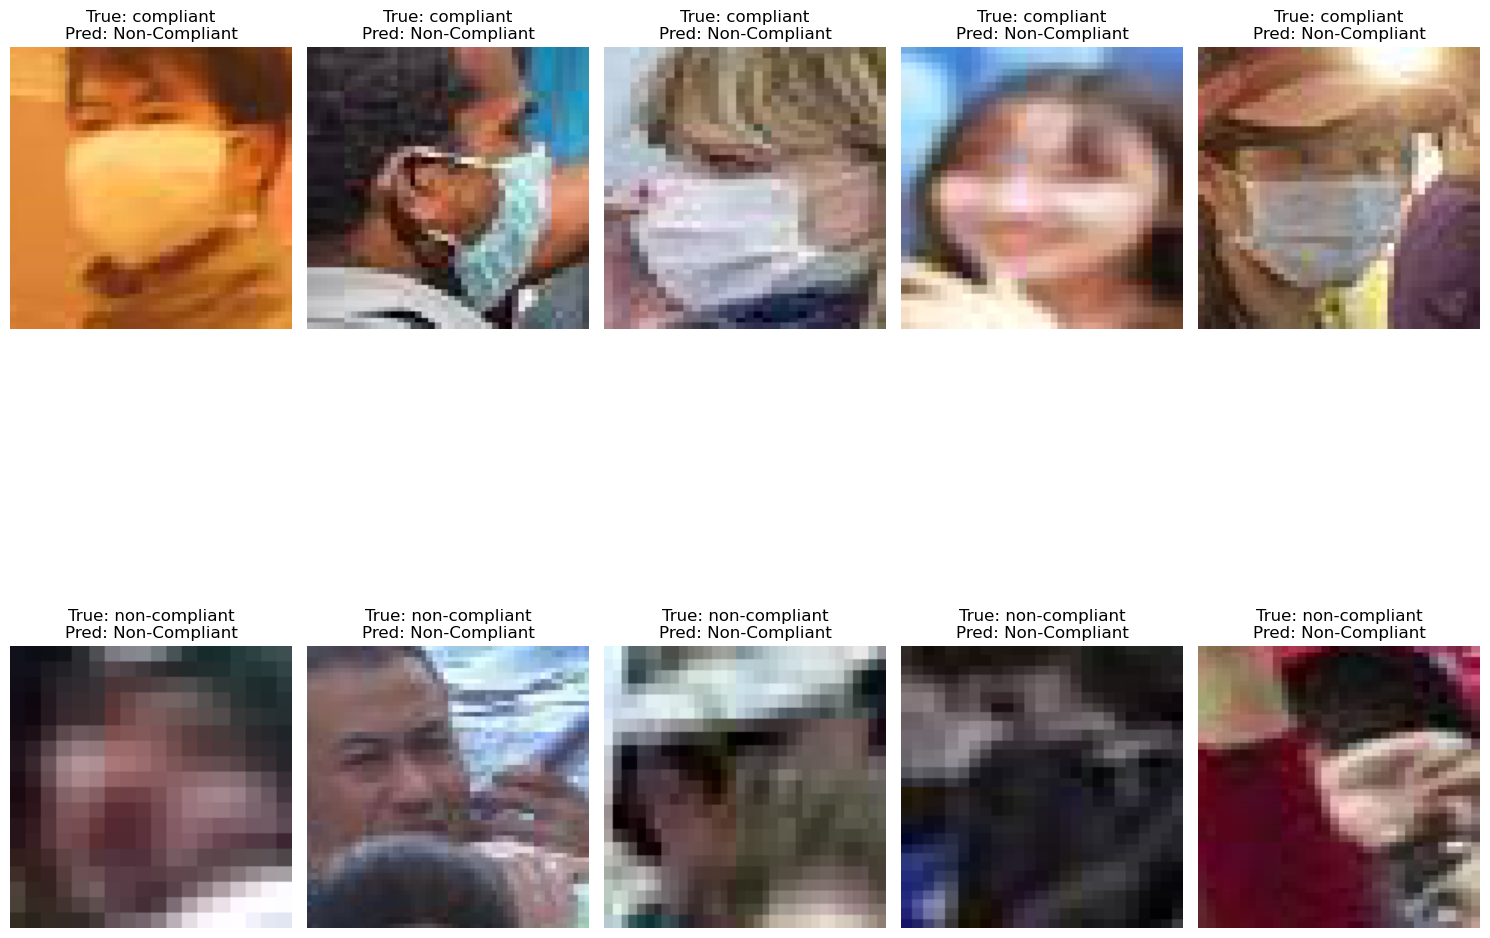

In [30]:
test_dir = "SF-MASK/test" 
test_model_on_random_images(model, test_dir, num_images=5)

## Graphics

# Other Images Resolution

# New model 

**160x160**



## Pre-processing

In [31]:
# Générateur pour l'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                # Normalisation
    rotation_range=20,                # Rotation aléatoire
    width_shift_range=0.2,            # Décalage horizontal
    height_shift_range=0.2,           # Décalage vertical
    shear_range=0.2,                  # Cisaillement
    zoom_range=0.2,                   # Zoom
    horizontal_flip=True,             # Retournement horizontal
    validation_split=0.2              # Séparation train/val
)

# Générateur pour le test sans augmentation
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Générateur pour l'ensemble d'entraînement
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),          # Redimensionner les images
    batch_size=32,                   # Taille des lots
    class_mode='binary',             # Classification binaire
    subset='training'                # Ensemble d'entraînement
)

# Générateur pour l'ensemble de validation
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary',
    subset='validation'              # Ensemble de validation
)

# Générateur pour l'ensemble de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(160, 160),
    batch_size=32,
    class_mode='binary'
)

Found 29726 images belonging to 2 classes.
Found 7430 images belonging to 2 classes.
Found 8670 images belonging to 2 classes.


In [32]:
# Charger EfficientNetB0 pré-entraîné
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(160, 160, 3))

# Ajouter des couches personnalisées pour la classification binaire
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Réduction de dimension
x = Dropout(0.5)(x)                   # Régularisation
predictions = Dense(1, activation="sigmoid")(x)  # Activation sigmoïde pour la classification binaire

# Construire le modèle complet
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches du modèle de base pour l'entraînement initial
for layer in base_model.layers:
    layer.trainable = False

In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 217s 232ms/step - loss: 0.6918 - accuracy: 0.5530 - val_loss: 0.6849 - val_accuracy: 0.5756
Epoch 2/5
928/928 [==============================] - 214s 230ms/step - loss: 0.6894 - accuracy: 0.5597 - val_loss: 0.6849 - val_accuracy: 0.5754
Epoch 3/5
928/928 [==============================] - 223s 240ms/step - loss: 0.6876 - accuracy: 0.5613 - val_loss: 0.7156 - val_accuracy: 0.4247
Epoch 4/5
928/928 [==============================] - 234s 252ms/step - loss: 0.6885 - accuracy: 0.5626 - val_loss: 0.6842 - val_accuracy: 0.5757
Epoch 5/5
928/928 [==============================] - 250s 269ms/step - loss: 0.6869 - accuracy: 0.5665 - val_loss: 0.6816 - val_accuracy: 0.5757


In [34]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)

Epoch 1/5
928/928 [==============================] - 842s 904ms/step - loss: 0.1897 - accuracy: 0.9269 - val_loss: 1.3463 - val_accuracy: 0.4247
Epoch 2/5
928/928 [==============================] - 898s 967ms/step - loss: 0.1387 - accuracy: 0.9483 - val_loss: 46.2069 - val_accuracy: 0.5199
Epoch 3/5
928/928 [==============================] - 878s 946ms/step - loss: 0.1208 - accuracy: 0.9556 - val_loss: 1.3347 - val_accuracy: 0.4243
Epoch 4/5
928/928 [==============================] - 858s 924ms/step - loss: 0.1116 - accuracy: 0.9582 - val_loss: 3.6854 - val_accuracy: 0.4242
Epoch 5/5
928/928 [==============================] - 775s 835ms/step - loss: 0.1011 - accuracy: 0.9618 - val_loss: 1.7504 - val_accuracy: 0.6127


In [35]:
model.save_weights("./models/efficientnet_mask_detection_weights_160.h5")

1/1 [==============================] - 0s 22ms/step


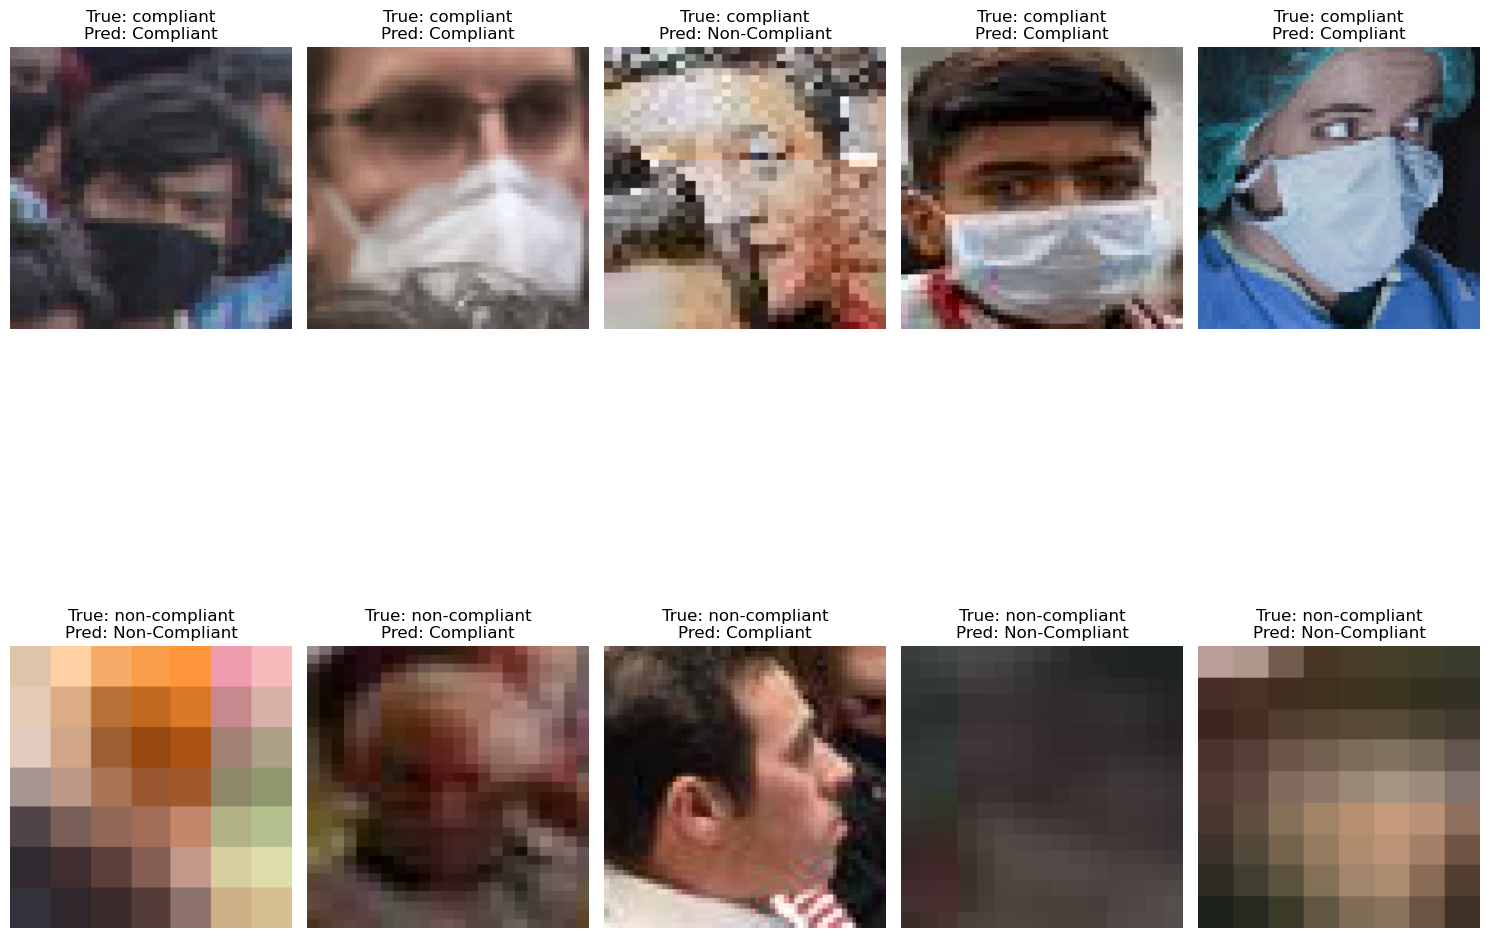

In [37]:
test_dir = "SF-MASK/test" 
test_model_on_random_images(model, test_dir, num_images=5, target_size=(160,160))

# Resolution 224x244 for EfficientNet

## Padding and resizing

In [13]:
output_dir_train = "./SF-MASK-dataset-padded/train"
output_dir_test = "./SF-MASK-dataset-padded/test"

In [25]:
pad_and_resize(train_dir, output_dir_train)
pad_and_resize(test_dir, output_dir_test)

python(7496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Processing non-compliant: 100%|██████████| 5048/5048 [01:00<00:00, 83.24it/s]


In [34]:
train_loader, val_loader, test_loader = get_dataloaders(
    train_dir=output_dir_train,
    test_dir=output_dir_test,
    augment=True,
    batch_size=BATCH_SIZE,
    target_size=TARGET_SIZE
)

Found 29726 images belonging to 3 classes.
Found 7430 images belonging to 3 classes.
Found 8670 images belonging to 2 classes.


In [36]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)

output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=output)

In [37]:
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [35]:
print(train_loader.class_indices)
print(val_loader.class_indices)

{'compliant': 0, 'non-compliant': 1}
{'compliant': 0, 'non-compliant': 1}


In [38]:
lr_callback = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=10,
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 416s 444ms/step - accuracy: 0.5579 - loss: 0.6918 - val_accuracy: 0.5755 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 2/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 473s 509ms/step - accuracy: 0.5584 - loss: 0.6902 - val_accuracy: 0.5755 - val_loss: 0.6820 - learning_rate: 0.0010
Epoch 3/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 489s 526ms/step - accuracy: 0.5563 - loss: 0.6898 - val_accuracy: 0.4245 - val_loss: 0.6946 - learning_rate: 0.0010
Epoch 4/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 472s 507ms/step - accuracy: 0.5641 - loss: 0.6878 - val_accuracy: 0.5755 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 5/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 470s 506ms/step - accuracy: 0.5745 - loss: 0.6837 - val_accuracy: 0.5755 - val_loss: 0.6842 - learning_rate: 5.0000e-04
Epoch 6/10
929/929 ━━━━━━━━━━━━━━━━━━━━ 480s 516ms/step - accuracy: 0.5724 - loss: 0.6844 - val_accuracy: 0.5755 - val_loss: 0.6821 - learning_rate: 5.0000e-04


In [40]:
loss, accuracy = model.evaluate(test_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

model.save_weights("./models/efficientnet_mask_detection_weights_224.weights.h5")

271/271 ━━━━━━━━━━━━━━━━━━━━ 86s 317ms/step - accuracy: 0.7799 - loss: 0.6177
Test Accuracy: 41.78%


In [41]:
import plotly.graph_objects as go

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

fig = go.Figure()

# Courbes de précision
fig.add_trace(go.Scatter(
    x=list(epochs), y=train_accuracy,
    mode='lines+markers',
    name='Train Accuracy',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=list(epochs), y=val_accuracy,
    mode='lines+markers',
    name='Validation Accuracy',
    line=dict(color='orange')
))

# Courbes de perte
fig.add_trace(go.Scatter(
    x=list(epochs), y=train_loss,
    mode='lines+markers',
    name='Train Loss',
    line=dict(color='green')
))
fig.add_trace(go.Scatter(
    x=list(epochs), y=val_loss,
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='red')
))

# Mettre en forme les axes et le titre
fig.update_layout(
    title='Model Training and Validation Metrics',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='Value'),
    legend=dict(x=0, y=1),
    template='plotly_white'
)

# Afficher le graphique
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


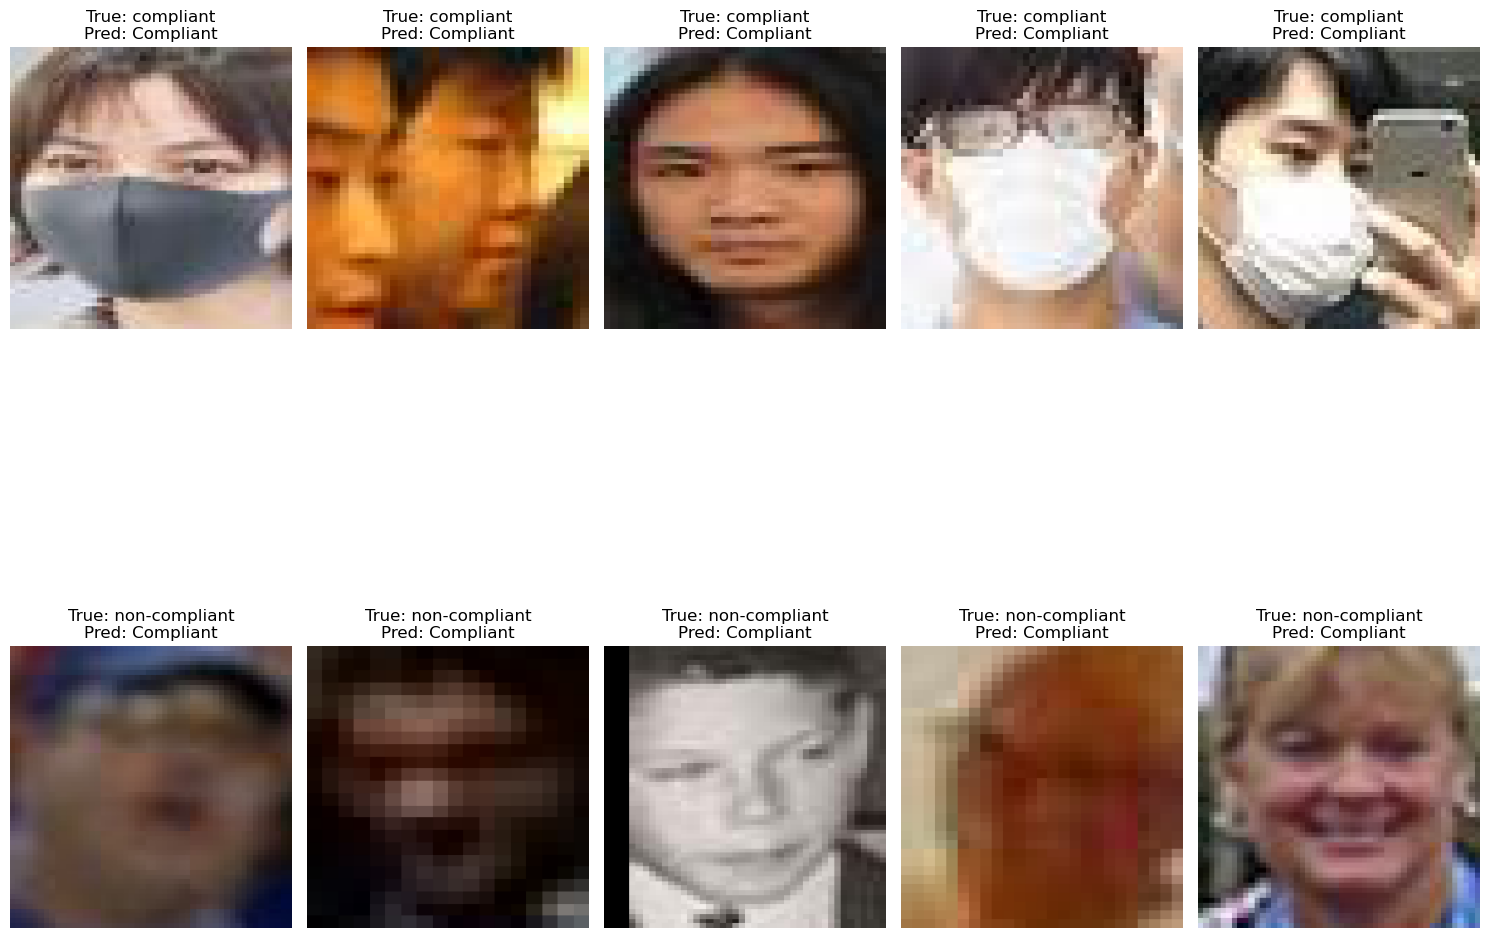

In [47]:
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=output)

model.load_weights("./models/efficientnet_mask_detection_weights_224.weights.h5")

test_model_on_random_images(model, "SF-MASK/test", num_images=5, target_size=(224, 224))

## Last layer training

In [14]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

train_loader, val_loader, test_loader = get_dataloaders(
    train_dir=output_dir_train,
    test_dir=output_dir_test,
    augment=True,
    batch_size=BATCH_SIZE,
    target_size=TARGET_SIZE
)

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)  
output = Dense(1, activation="sigmoid", kernel_regularizer=l2(0.01))(x)
model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=5,
    callbacks=[early_stopping, lr_callback]
)

Found 29726 images belonging to 3 classes.
Found 7430 images belonging to 3 classes.
Found 8670 images belonging to 2 classes.


/Users/pierre/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 2180s 2s/step - accuracy: 0.7214 - loss: 2.7801 - val_accuracy: 0.4779 - val_loss: 2.7320 - learning_rate: 1.0000e-05
Epoch 2/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 2314s 2s/step - accuracy: 0.9139 - loss: 2.0743 - val_accuracy: 0.7751 - val_loss: 2.0342 - learning_rate: 1.0000e-05
Epoch 3/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 2069s 2s/step - accuracy: 0.9394 - loss: 1.6366 - val_accuracy: 0.6253 - val_loss: 1.9078 - learning_rate: 1.0000e-05
Epoch 4/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 2256s 2s/step - accuracy: 0.9530 - loss: 1.2850 - val_accuracy: 0.9114 - val_loss: 1.1958 - learning_rate: 1.0000e-05
Epoch 5/5
929/929 ━━━━━━━━━━━━━━━━━━━━ 2280s 2s/step - accuracy: 0.9597 - loss: 1.0060 - val_accuracy: 0.8346 - val_loss: 1.1245 - learning_rate: 1.0000e-05


In [15]:
model.save('./models/efficientnet_mask_detection_224.h5')

In [16]:
loss, accuracy = model.evaluate(test_loader)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

/Users/pierre/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


271/271 ━━━━━━━━━━━━━━━━━━━━ 91s 334ms/step - accuracy: 0.8189 - loss: 1.2571
Test Accuracy: 88.40%


In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

fig = go.Figure()

# Courbes de précision
fig.add_trace(go.Scatter(
    x=list(epochs), y=train_accuracy,
    mode='lines+markers',
    name='Train Accuracy',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=list(epochs), y=val_accuracy,
    mode='lines+markers',
    name='Validation Accuracy',
    line=dict(color='orange')
))

# Courbes de perte
fig.add_trace(go.Scatter(
    x=list(epochs), y=train_loss,
    mode='lines+markers',
    name='Train Loss',
    line=dict(color='green')
))
fig.add_trace(go.Scatter(
    x=list(epochs), y=val_loss,
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='red')
))

# Mettre en forme les axes et le titre
fig.update_layout(
    title='Model Training and Validation Metrics',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='Value'),
    legend=dict(x=0, y=1),
    template='plotly_white'
)

# Afficher le graphique
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


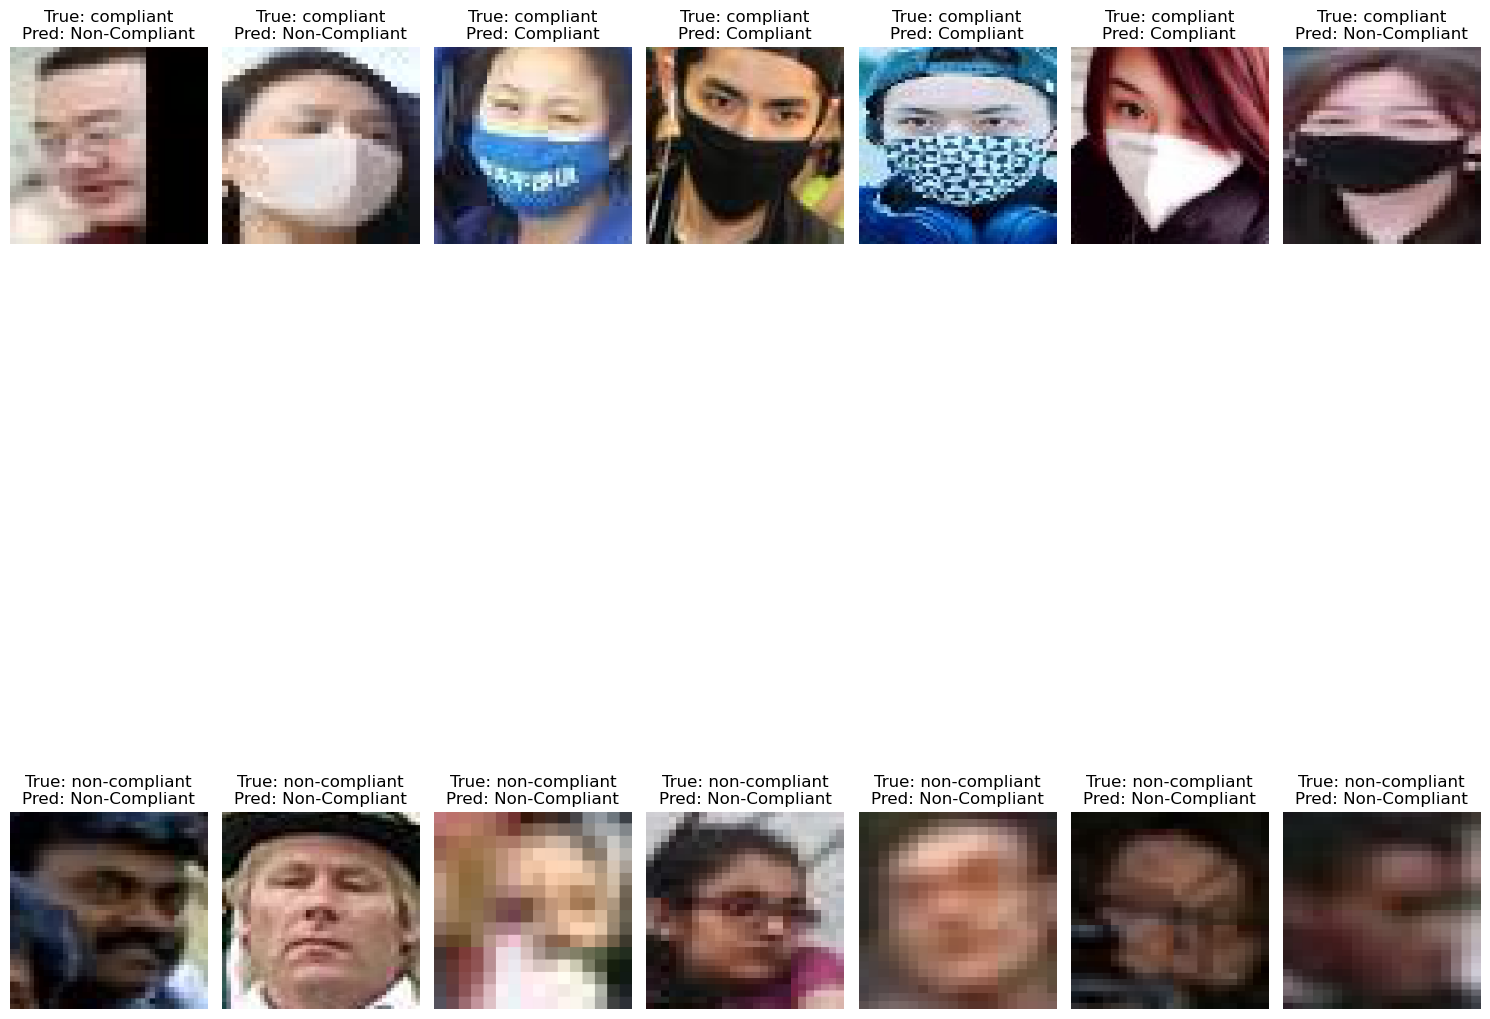

In [21]:
test_model_on_random_images(model, "SF-MASK/test", num_images=7, target_size=(224, 224))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


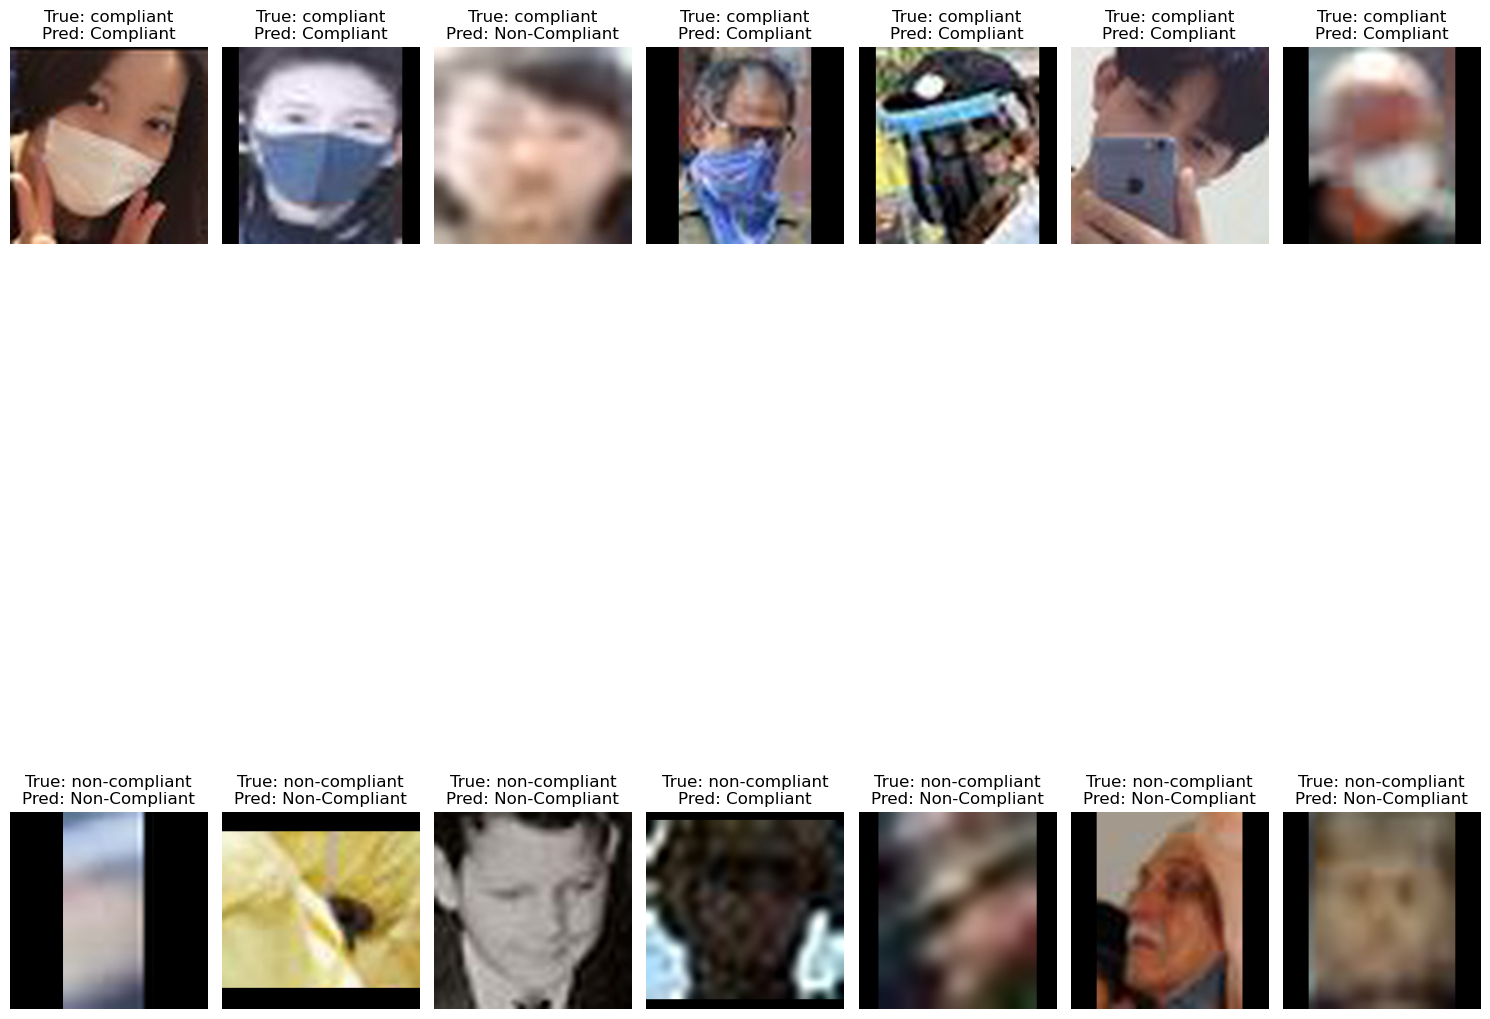

In [22]:
test_model_on_random_images(model, "SF-MASK-dataset-padded/test", num_images=7, target_size=(224, 224))

# Video Application

In [20]:
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=output)

model.load_weights("./models/efficientnet_mask_detection_weights_224.weights.h5")

print("Model Loaded.")

cap = cv2.VideoCapture(0)

print("Appuyez sur 'q' pour quitter.")
while True:

    ret, frame = cap.read()
    if not ret:
        print("Erreur : Impossible de lire la vidéo.")
        break

    frame = cv2.resize(frame, TARGET_SIZE)

    label, confidence = predict_mask(frame, model, TARGET_SIZE)

    cv2.putText(
        frame,
        f"{label} ({confidence*100:.2f}%)",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (0, 255, 0) if label == "Compliant" else (0, 0, 255),
        2,
        cv2.LINE_AA,
    )
    cv2.imshow("Mask Detection (224x224)", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

Model Loaded.


2024-12-08 21:28:14.366 python[12663:412414] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Appuyez sur 'q' pour quitter.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━

: 